In [44]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [45]:
train_csv = './data/Stock_data/AMZNtrain.csv'
data = pd.read_csv(train_csv)
data.columns
data.shape

(1258, 7)

In [46]:
all_data = data['Close'].values.astype(float)

In [47]:
print(all_data)

[ 397.970001  396.440002  393.630005 ... 1461.640015 1478.02002
 1501.969971]


In [48]:
test_data_size = 200

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [49]:
print(len(train_data))
print(len(test_data))

1058
200


In [50]:
#print(test_data)

In [51]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [52]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-0.83068995]
 [-0.83302326]
 [-0.83730862]
 [-0.83059845]
 [-0.82466601]]
[[0.9702617 ]
 [1.        ]
 [0.98442939]
 [0.98872992]
 [0.97549248]]


In [53]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [54]:
train_window = 12

In [55]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [56]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [57]:
train_inout_seq[:5]

[(tensor([-0.8307, -0.8330, -0.8373, -0.8306, -0.8247, -0.8261, -0.8312, -0.8413,
          -0.8313, -0.8339, -0.8340, -0.8282]), tensor([-0.8168])),
 (tensor([-0.8330, -0.8373, -0.8306, -0.8247, -0.8261, -0.8312, -0.8413, -0.8313,
          -0.8339, -0.8340, -0.8282, -0.8168]),
  tensor([-0.8207])),
 (tensor([-0.8373, -0.8306, -0.8247, -0.8261, -0.8312, -0.8413, -0.8313, -0.8339,
          -0.8340, -0.8282, -0.8168, -0.8207]), tensor([-0.8278])),
 (tensor([-0.8306, -0.8247, -0.8261, -0.8312, -0.8413, -0.8313, -0.8339, -0.8340,
          -0.8282, -0.8168, -0.8207, -0.8278]), tensor([-0.8465])),
 (tensor([-0.8247, -0.8261, -0.8312, -0.8413, -0.8313, -0.8339, -0.8340, -0.8282,
          -0.8168, -0.8207, -0.8278, -0.8465]), tensor([-0.8485]))]

In [58]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [59]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [60]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


## Training the model

In [20]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')


epoch:   1 loss: 0.00104855
epoch:  26 loss: 0.00021763
epoch:  51 loss: 0.00042334
epoch:  76 loss: 0.00000707
epoch: 101 loss: 0.00011331
epoch: 126 loss: 0.00051777
epoch: 149 loss: 0.0007184464


## MAking predictions

In [61]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.8689378499984741, 0.8399620652198792, 0.8503324389457703, 0.8859573602676392, 0.9073537588119507, 0.918578028678894, 0.9290397763252258, 0.9702616930007935, 1.0, 0.9844293594360352, 0.9887298941612244, 0.9754924774169922]


In [62]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [63]:
test_inputs[fut_pred:]


[0.035339441150426865,
 0.03892160952091217,
 0.04110166057944298,
 0.04173514246940613,
 0.04159665107727051,
 0.041183214634656906,
 0.040745511651039124,
 0.040382131934165955,
 0.04011337459087372,
 0.0399288609623909,
 0.039809711277484894,
 0.03973541036248207]

In [64]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)


[[965.8427919 ]
 [968.19169135]
 [969.62119444]
 [970.03658118]
 [969.94576961]
 [969.67467106]
 [969.38766046]
 [969.14938511]
 [968.97315555]
 [968.85216627]
 [968.77403744]
 [968.72531684]]


In [65]:
x = np.arange(1246, 1258, 1)
print(x)

[1246 1247 1248 1249 1250 1251 1252 1253 1254 1255 1256 1257]


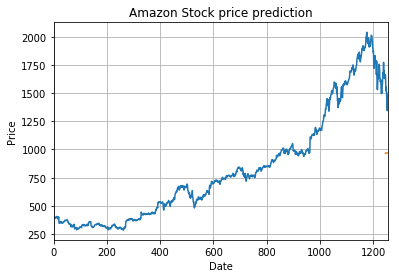

In [66]:
plt.title('Amazon Stock price prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(data['Close'])
plt.plot(x,actual_predictions)
plt.show()


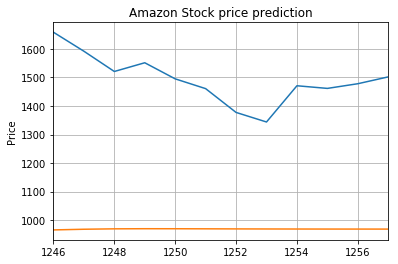

In [67]:
plt.title('Amazon Stock price prediction')
plt.ylabel('Price')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(data['Close'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()
